# generate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from tqdm.notebook import tqdm
from time import sleep
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# coding:utf-8
'''
author:
    zhangzhaopeng
usage:
    AFAGPS算法计算功率谱
attention:
    get_extremum, get_AFAGPS_graph为辅助功能,
    与功率谱计算无关系.
'''


__author__ = 'zhangzhaopeng'


def get_extremum(xx, yy, key=max, n=10):
    """
    获得至多n个极值, 如果key=max则获得极大值,
    如果key=min则获得极小值.

    Parameters
    ----------
    xx: list
        x axis data
    yy: list
        y axis data
    key: func
        default: max
        key for  extremum.
    n: int
        default: 10
        at most n extremum.

    Returns
    -------
    a list of at most n numbers.
    """
    if n == 0:
        return [()]
    data = []
    for x, y, idx in zip(xx, yy, range(len(xx))):
        if y != 0:
            data.append((x, y, idx))
    extremums = []
    cutoff = int(len(data) * 1.0 / n)
    for i in range(n):
        start = i * cutoff
        end = (1 + i) * cutoff
        x, y, idx = key(data[start:end], key=lambda t: t[1])
        if idx + 1 < len(yy):
            if key(yy[idx], yy[idx + 1], yy[idx - 1]) == yy[idx]:
                extremums.append((x, y, idx))
        else:
            extremums.append((x, y, idx))
    return extremums


def get_AFAGPS_graph(picName, x, y=None, h=0.2, style=None):
    """
    作功率谱图像

    Parameters
    ----------
    picName: str
        default: None
        图像名称
    x,y:
        若y为None，则计算列表x的功率谱结果并作图;
        否则，直接以x,y的值作图
    h:
        指定AFAGPS算法中过滤系数
    style:
        如果为'D'则作竖线图

    Returns
    -------
    exs: list
        极值对.
    """
    if y == None:
        xx, yy = get_AFAGPS(x, h)
    else:
        xx, yy = x, y
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    max_yy = max(yy)
    yy = [y / max_yy for y in yy]
    fig = plt.figure(figsize=(10, 10), dpi=300)
    #plt.plot(xx, yy)
    ax = fig.add_subplot(111)
    exs = []
    for i in range(1, len(xx) - 1):
        if yy[i] > yy[i-1] and yy[i] > yy[i+1]:
            exs.append((xx[i], yy[i], i))
            if style == 'D':
                ax.add_line(Line2D((xx[i], xx[i]), (0, yy[i]), color='red'))
    if style != 'D':
        ax.scatter(xx, yy, linewidths=0.01)

    plt.xlim(0, 2 * np.pi)
    plt.ylim(0, 1.1)
    plt.xticks((0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi),
               (r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{4}$", r"$2\pi$"))

    plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps计算功率谱\\"+picName+".png")
    plt.close()
    return exs, max_yy


def listConvolve(x, y):
    """
    calculate linear convolution of two lists.

    Attention
    ---------
        len(x)=m, len(y)=n, m<=n
        return n length list: circular convolution of x and y
    """
    ########## old #################
    #result = np.convolve(x, y)[len(x)-1:len(y)]
    ########## new #################
    x.extend([0] * (len(y) - len(x)))
    result = np.fft.ifft(np.fft.fft(x) * np.fft.fft(y)).real
    return result


def get_AFAGPS(X, tag='D', h=0.2):
    '''
    Parameters
    ----------
    X: list
        需要计算功率谱的数据
    tag: str
    default: D
        C: continuous Fourier Transform
        D: Discrete Fourier Transfrom
    h: float
        指定AFAGPS算法中过滤系数

    Examples
    --------
    ref to test.py
    '''
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
   # X = [(i - mean) / std for i in X]
    # reverse X
    X_reverse = X[::-1]
    # add zeros
    X_reverse.extend([0] * N)
    X=X_reverse[::-1]
	
    # circular convolution, the same as matlab function "cconv"
    Rn = listConvolve(X, X_reverse)
    Rn = [1.0 / (N-i) * Rn[i] for i in range(1000)]   ######change1
    # filt
    for idx, i in enumerate(Rn):
        if abs(i / Rn[0]) <= h:
            Rn[idx] = 0
    # add zeros
    #Rn.extend(len(Rn) * [0])    ########change2

    plist = [2 * value.real - Rn[0] for value in np.fft.fft(Rn)]
    #m = max([abs(i) for i in plist])
    #plist = [abs(i) / m for i in plist]

    if tag == 'C':
        """CFT"""
        yy = [i + j for i,
              j in zip(plist[len(plist) // 2 + 1:], plist[:len(plist) // 2 + 1])]
    elif tag == 'D':
        """DFT"""
        yy = plist
    '''
    else:
        import sys
        print("Error!")
        sys.exit(1)
        '''
    xx = []
    for i in range(len(yy)):
        xx.append(i * np.pi / len(yy))
    return xx, yy

def get_abs2_ps(X):
    """
    only for DFT.
    """
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
    X = [(i - mean) / std for i in X]
    R = np.fft.fft(X)
    absR = [abs(r)**2 for r in R]
    m = np.mean(absR)
    for idx, r in enumerate(absR):
        if r < m:
            absR[idx] = 0.
    xx = []
    for i in range(len(absR)):
        xx.append(i * 2 * np.pi / len(absR))
    return xx, absR

# functions

In [3]:
def listConvolve(x, y):
    """
    calculate linear convolution of two lists.

    Attention
    ---------
        len(x)=m, len(y)=n, m<=n
        return n length list: circular convolution of x and y
    """
    ########## old #################
    #result = np.convolve(x, y)[len(x)-1:len(y)]
    ########## new #################
    x.extend([0] * (len(y) - len(x)))
    result = np.fft.ifft(np.fft.fft(x) * np.fft.fft(y)).real
    return result

In [4]:
da = pd.read_csv(r'D:\e\南开光伏课题数据集及说明\NK2_GF\评测数据\气象数据\Station_1.csv')
da = np.array(da)
da
c1 = da[0:10000, 2]
c2=da[0:10000,3]
c3=da[0:10000,4]
c4=da[0:10000,5]
c5=da[0:10000,6]
#ax,ay=get_AFAGPS(c1,h=0.2)
#max_ay = max(ay)
#ay = [y / max_ay for y in ay]
#plt.figure(figsize=(40,10))
#plt.plot(ax,ay)</div><i class="fa fa-lightbulb-o "></i>

In [6]:
c2=np.cos(c2.astype(float))

In [7]:
def get_AFAGPS(X, tag='D', h=0.2):
    '''
    Parameters
    ----------
    X: list
        需要计算功率谱的数据
    tag: str
    default: D
        C: continuous Fourier Transform
        D: Discrete Fourier Transfrom
    h: float
        指定AFAGPS算法中过滤系数

    Examples
    --------
    ref to test.py
    '''
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
    X = [(i - mean) / std for i in X]
    # reverse X
    X_reverse = X[::-1]
    # add zeros
    X_reverse.extend([0] * N)
    X=X_reverse[::-1]
	
    # circular convolution, the same as matlab function "cconv"
    Rn = listConvolve(X, X_reverse)
    Rn = [1.0 / (N-i) * Rn[i] for i in range(1000)]   ######change1
    # filt
    for idx, i in enumerate(Rn):
        if abs(i / Rn[0]) <= h:
            Rn[idx] = 0
    # add zeros
    Rn.extend(len(Rn) * [0])    ########change2

    plist = [2 * value.real - Rn[0] for value in np.fft.fft(Rn)]
    m = max([abs(i) for i in plist])
    plist = [abs(i) / m for i in plist]

    if tag == 'C':
        """CFT"""
        yy = [i + j for i,
              j in zip(plist[len(plist) // 2 + 1:], plist[:len(plist) // 2 + 1])]
    elif tag == 'D':
        """DFT"""
        yy = plist
    '''
    else:
        import sys
        print("Error!")
        sys.exit(1)
        '''
    xx = []
    for i in range(len(yy)):
        xx.append(i * np.pi / len(yy))
    return xx, yy

In [8]:
def sfgps(X):
    X, N = [float(i) for i in X], len(X)
    # normalized
    mean, std = np.mean(X), np.std(X)
    X = [(i - mean) / std for i in X]
    yy=(abs(np.fft.fft(X)))**2
    ave=1/(N+1)*sum(X)
    y=list()
    for m in yy:
        if m>ave+std:
            y.append(m)
        else:
            y.append(std**2)
    return y

In [9]:
def getsfgps(X,name='no'):
    y=sfgps(X)
    #max_y = max(y)
    #y = [ay / max_y for ay in y]
    #x=range(0,10000)
    #plt.figure(figsize=(30,10),dpi=300)
    #plt.bar(x,y,1)
    #plt.plot(y)
    #plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps功率谱new\\"+name+".png")
    print('getsfgps done')
    return y

In [10]:
def getgraph(x,name,hh):
    ax,ay=get_AFAGPS(x,h=hh)
    max_ay = max(ay)
    ay = [y / max_ay for y in ay]
    #plt.figure(figsize=(20,10),dpi=300)
    #plt.plot(ax,ay)
    #plt.savefig("C:\\Users\\Lenovo\\Desktop\\气象水文\\afagps功率谱new\\"+name+"10000afagps.png")

In [11]:
def getafa(x,hh):
    ax,ay=get_AFAGPS(x,h=hh)
    #max_ay = max(ay)
    #ay = [y / max_ay for y in ay]
    return ay

In [10]:
'''
getgraph(c1,'第一列',0.2)
getgraph(c2,'第二列',0.2)
getgraph(c3,'第三列',0.2)
getgraph(c4,'第四列',0.2)
getgraph(c5,'第五列',0.2)
'''

"\ngetgraph(c1,'第一列',0.2)\ngetgraph(c2,'第二列',0.2)\ngetgraph(c3,'第三列',0.2)\ngetgraph(c4,'第四列',0.2)\ngetgraph(c5,'第五列',0.2)\n"

In [12]:
def recover(c):
    da=getsfgps(c)
    #da=getafa(c)
    ind=[da.index(a) for a in da if a >0.2]
    A=[]
    for i in ind:
        A.append(da[i])
    index=ind[0:math.ceil(len(ind)/2)]
    x=np.linspace(0,208*np.pi,9984)
    y=[]
    yy=[0 for i in range(9984)]
    for i in range(0,math.ceil(len(ind)/2)):
        y.append(np.sqrt(A[i])*np.cos(index[i]/10000*x))
    #for m in y:
    #   yy=yy+m
    #return yy
    return y

In [13]:
#return A,index
def getda(c):
    da=getsfgps(c)
    #da=getafa(c,0.2)
    ind=[da.index(a) for a in da if a >0.2]
    A=[]
    for i in ind:
        A.append(da[i])
    index=ind[0:math.ceil(len(ind)/2)]
    print('getda done')
    return A,index

In [14]:
#return yy
def getre(A,index,theta):
    x=np.linspace(0,208*np.pi,9984)
    theta=np.array([theta for i in range(len(x))])
    y=[]
    yy=[0 for i in range(9984)]
    for i in range(0,len(index)-1):
        if A[i]==max(A):
            y.append(np.sqrt(A[i])*np.cos((index[i]+1)/96*x+theta))
        else:
            y.append(np.sqrt(A[i])*np.cos((index[i]+1)/96*x))
    for m in y:
        yy=yy+m
    print('getre done')
    return yy
#return mingap
def mingap(c):
    m=np.linspace(0,2*np.pi,1000)
    gaap=[]
    for i in m:
        A,index=getda(c)
        yy=getre(A,index,i)
        me=np.mean(yy)
        st=np.std(yy)
        yy=(yy-me)/st
        cme=np.mean(c)
        cst=np.std(c)
        c=(c-cme)/cst
        gap=sum([abs(yy[n]-c[n]) for n in range(len(yy)-1)])
        gaap.append(gap)
    return min(gaap)
    #return gaap

In [15]:
#show figure
def seegap(c):
    m=np.linspace(0,6.28,99)
    gaap=[]
    for i in m:
        print(i)
        A,index=getda(c)
        yy=getre(A,index,i)
        me=np.mean(yy)
        st=np.std(yy)
        yy=(yy-me)/st
        cme=np.mean(c)
        cst=np.std(c)
        c=(c-cme)/cst
        gap=sum([abs(yy[n]-c[n]) for n in range(len(yy)-1)])
        gaap.append(gap)
    mi=min(gaap)
    print(np.where(gaap==mi))
    y=getre(A,index,m[np.where(gaap==mi)][0])
    #plt.plot(c)
    #plt.plot(y)
    #plt.show()
    return y

In [16]:
#return certain gap
def findgap(c,i):
    A,index=getda(c)
    yy=getre(A,index,i)
    me=np.mean(yy)
    st=np.std(yy)
    yy=(yy-me)/st
    cme=np.mean(c)
    cst=np.std(c)
    c=(c-cme)/cst
    gap=sum([abs(yy[n]-c[n]) for n in range(len(yy)-1)])
    return gap

In [17]:
def stdlise(x):
    me,std=np.mean(x),np.std(x)
    x=(x-me)/std
    return x

In [18]:
def getfig(y,c,no=str(1)):
    plt.figure(figsize=(200,30))
    plt.plot(stdlise(y),label='simulate')
    plt.plot(stdlise(c),label='origin')
    plt.legend()
    plt.savefig('C:\\Users\\Lenovo\\Desktop\\气象水文\\还原'+no+'.png')
    plt.close()
    plt.clf()

# furthur

In [19]:
def minimize(c):
    A,index=getda(c)
    m=np.linspace(0,6.28,99)
    x=np.linspace(0,208*np.pi,9984)
    Y=[0 for i in range(len(x))]
    for i in range(0,len(index)-1):
        gaap=[]
        for theta in m:
            the=np.array([theta for i in range(len(x))])
            y=(np.sqrt(A[i])*np.cos((index[i]+1)/96*x+the)).astype(list)
            test=[m+n for m,n in zip(Y,y)]
            gap=sum([abs(test[n]-c1[n]) for n in range(len(Y)-1)])
            gaap.append(gap)
        mk=np.array([m[gaap.index(min(gaap))] for i in range(len(x))])
        yfori=(np.sqrt(A[i])*np.cos((index[i]+1)/96*x+mk)).astype(list)
        Y=[m+n for m,n in zip(Y,yfori)]
    return Y
'''       
for m in y:
    yy=yy+m
print('getre done')

gaap=[]
    y=[]
    yy=[0 for i in range(9984)]

    
    for i in m:
        print(i)
        A,index=getda(c)
        yy=getre(A,index,i)
        me=np.mean(yy)
        st=np.std(yy)
        yy=(yy-me)/st
        cme=np.mean(c)
        cst=np.std(c)
        c=(c-cme)/cst
        gap=sum([abs(yy[n]-c[n]) for n in range(len(yy)-1)])
        gaap.append(gap)
    mi=min(gaap)
    print(np.where(gaap==mi))
    y=getre(A,index,m[np.where(gaap==mi)][0])
'''

"       \nfor m in y:\n    yy=yy+m\nprint('getre done')\n\ngaap=[]\n    y=[]\n    yy=[0 for i in range(9984)]\n\n    \n    for i in m:\n        print(i)\n        A,index=getda(c)\n        yy=getre(A,index,i)\n        me=np.mean(yy)\n        st=np.std(yy)\n        yy=(yy-me)/st\n        cme=np.mean(c)\n        cst=np.std(c)\n        c=(c-cme)/cst\n        gap=sum([abs(yy[n]-c[n]) for n in range(len(yy)-1)])\n        gaap.append(gap)\n    mi=min(gaap)\n    print(np.where(gaap==mi))\n    y=getre(A,index,m[np.where(gaap==mi)][0])\n"

In [93]:
type(index)

list

In [39]:
for c,i in zip((c1,c2,c3,c4,c5),('11','12','13','14','15')):
    print(i)
    getfig(stdlise(minimize(c)),stdlise(c),i) 

11
getsfgps done
getda done
12
getsfgps done
getda done
13
getsfgps done
getda done
14
getsfgps done
getda done
15
getsfgps done
getda done


<Figure size 432x288 with 0 Axes>

In [28]:
x=np.linspace(0,208*np.pi,9984)
y=np.cos(x)

In [21]:
getfig(stdlise(minimize(y)),stdlise(y),'test')

getsfgps done
getda done


KeyboardInterrupt: 

getsfgps done
getda done


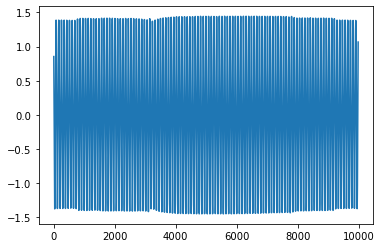

In [29]:
plt.plot(stdlise(minimize(y)))

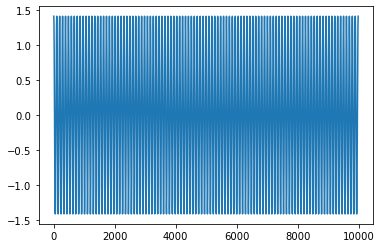

In [30]:
plt.plot(stdlise(y))

# APPLY

In [58]:
for c,i in zip((c1,c2,c3,c4,c5),('1','2','3','4','5')):
    print(i)
    getfig(stdlise(seegap(c)),stdlise(c),i)

1
0.0
getsfgps done
getda done
getre done
0.06408163265306123
getsfgps done
getda done
getre done
0.12816326530612246
getsfgps done
getda done
getre done
0.1922448979591837
getsfgps done
getda done
getre done
0.2563265306122449
getsfgps done
getda done
getre done
0.32040816326530613
getsfgps done
getda done
getre done
0.3844897959183674
getsfgps done
getda done
getre done
0.4485714285714286
getsfgps done
getda done
getre done
0.5126530612244898
getsfgps done
getda done
getre done
0.576734693877551
getsfgps done
getda done
getre done
0.6408163265306123
getsfgps done
getda done
getre done
0.7048979591836735
getsfgps done
getda done
getre done
0.7689795918367348
getsfgps done
getda done
getre done
0.833061224489796
getsfgps done
getda done
getre done
0.8971428571428572
getsfgps done
getda done
getre done
0.9612244897959185
getsfgps done
getda done
getre done
1.0253061224489797
getsfgps done
getda done
getre done
1.089387755102041
getsfgps done
getda done
getre done
1.153469387755102
getsf

KeyboardInterrupt: 

In [79]:
getfig(stdlise(seegap(c2)),c2,'2')

0.0
getsfgps done
getda done
getre done
0.06408163265306123
getsfgps done
getda done
getre done
0.12816326530612246
getsfgps done
getda done
getre done
0.1922448979591837
getsfgps done
getda done
getre done
0.2563265306122449
getsfgps done
getda done
getre done
0.32040816326530613
getsfgps done
getda done
getre done
0.3844897959183674
getsfgps done
getda done
getre done
0.4485714285714286
getsfgps done
getda done
getre done
0.5126530612244898
getsfgps done
getda done
getre done
0.576734693877551
getsfgps done
getda done
getre done
0.6408163265306123
getsfgps done
getda done
getre done
0.7048979591836735
getsfgps done
getda done
getre done
0.7689795918367348
getsfgps done
getda done
getre done
0.833061224489796
getsfgps done
getda done
getre done
0.8971428571428572
getsfgps done
getda done
getre done
0.9612244897959185
getsfgps done
getda done
getre done
1.0253061224489797
getsfgps done
getda done
getre done
1.089387755102041
getsfgps done
getda done
getre done
1.153469387755102
getsfgp

<Figure size 432x288 with 0 Axes>

In [74]:
max(c2)

0.999999864364719

In [78]:
plt.figure(figsize=(200,5))
#plt.plot(stdlisec2),label='cos')
plt.plot(da[0:10000,3],label='c2')
plt.legend()
plt.savefig('C:\\Users\\Lenovo\\Desktop\\气象水文\\see.png')
plt.close()
plt.clf()

<Figure size 432x288 with 0 Axes>

# 测试样例

In [16]:
da=getsfgps(c1)
ind=[da.index(a) for a in da if a >0.2]
A=[]
for i in ind:
    A.append(da[i])
index=ind[0:math.ceil(len(ind)/2)]
print('getda done')
x=np.linspace(0,208*np.pi,9984)
theta=6
theta=np.array([theta for i in range(len(x))])
y=[]
yy=[0 for i in range(9984)]
for i in range(0,len(index)-1):
    if A[i]==max(A):
        y.append(np.sqrt(A[i])*np.cos((index[i]+1)/96*x+theta))
    else:
        y.append(np.sqrt(A[i])*np.cos((index[i]+1)/96*x))
for m in y:
    yy=yy+m
print('getre done')

getsfgps done
getda done
getre done


In [27]:
plt.figure(figsize=(200,30))
plt.plot(stdlise(yy))
plt.plot(stdlise(c1))
plt.savefig('C:\\Users\\Lenovo\\Desktop\\气象水文\\还原.png')
plt.close()
plt.clf()

<Figure size 432x288 with 0 Axes>

In [34]:
from tqdm.notebook import tqdm
from time import sleep

for i in tqdm(range(100)):
    sleep(0.01)


  0%|          | 0/100 [00:00<?, ?it/s]